# Homework #4 (Due 10/9/2019, 11:59pm)
## Hierarchical Models and the Theory of Variational Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

## Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
# Mount working directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/class/am207/HW4

# Import basic libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import sklearn as sk
import scipy as st
import time
from sklearn.linear_model import LinearRegression
from pymc3 import model_to_graphviz, Model

# Plot configs
fig_wide = (11, 4)
plt.rcParams.update({"axes.formatter.limits":(-3, 3)})
%matplotlib inline
%config InlineBackend.figure_format = "retina"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/class/am207/HW4


In [0]:
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

## Problem Description: Understanding EM and Variational Inference

In this problem, we will draw concrete connections between EM and variational inference by applying both methods to a certain class of latent variable models. You'll need to refer to relevant lecture notes on the derivations of EM and the derivation of the variational inference objective. This is an essay question that requires you to engage with complex derivations at a productive but still high level. No implementation is required.

### Non-Bayesian Latent Variable Model
Recall the class of latent variable models we studied in lecture:
<img src="fig/graphical_model.jpg" style="height:150px;">

### Bayesian Latent Variable Model
A Bayesian version of the same class of models involve adding priors for the model parameters:
<img src="fig/bayesian_model.jpg" style="height:150px;">



### Comparison and Discussion
1. **(Comparing ELBOs)** For the above type of Bayesian latent variable model, write down the ELBO for variational inference with a mean field variational family. Compare the variational inference ELBO for the Bayesian model to the expectation maximization ELBO for the non-Bayesian model. What are the differences and similarities between these two ELBOs?

  In both EM and variational inference we optimize the ELBO. Compare the update steps in EM to the update steps in Coordinate Ascent Variational Inference, draw a concrete analogy between them.
  
  ***Hint:*** To make both ELBO's comparable, make sure that both are in terms of $z, y, \theta, \phi$.
  <br><br>
  
2. **(Comparing ELBOs and KL-divergences)** Recall that the original objective of variational inference is to minimize a KL-divergence, we rewrote the objective to be that of maximizing the ELBO. Why is directly minimizing the KL-divergence in the original objective difficult (be specific about wherein the difficulty lies)? 

  In the derivation of the E-step of EM, we reframed an maximization of the ELBO problem as a minimization of a KL-divergence problem. In this case, why was the KL-divergence easier to minimize and the ELBO harder to maximize (use the instantiation of the E-step for Gaussian Mixture Models in Lecture 7 to help support your answer)? 

  In the notes for Lecture 8, we introduce a way to maximize the variational inference ELBO -- through coordinate ascent. In the derivation of the updates for coordinate ascent, there is a place where we reframed an maximization of the ELBO problem as an equivalent minimization of a KL-divergence problem. Write down the exact form of this equivalence (the two expressions are separated in the derivation by a bunch of lines, you'll need to identify both parts that you need). In this case, why was the KL-divergence easier to minimize and the ELBO harder to maximization (use the instantiation of the update for Gaussian Mixture Models in Lecture 8 to help support your answer)?

  Based on this analysis, can you draw some general conclusions about when we'd prefer to minimize the KL-divergence versus when we'd prefer to maximize the ELBO?<br><br>

3. **(The Mean Field Assumption and Coordinate Ascent)**  Describe exactly when and how the mean field assumption is used in the derivation of the coordinate ascent updates. <br><br>

4. **(Generalizability of CAVI)** Summarize what kind of derivations/math is needed in order instantiate Coordinate Ascent Variational Inference (CAVI) for a given new model (look at what we did for Gaussian Mixture Models in Lecture 8 and predict what you'd need to do for a new model). Based on this, discuss the potential draw backs of using CAVI for Bayesian inference in general. Do these draw backs mean that variational inference is not a practical method of inference? What problem(s) need to be solved in order to make variational inference easy to implement for any given Bayesian model?

#### 1.1 Comparing ELBOs
The ELBO function for the non-Bayesian EM case and the Bayesian VI case look like the following.

\begin{align}
\text{(EM)}\quad \text{ELBO}(\theta,\phi,q) &\sim \mathbb E_{q(z)} 
\left[ \ln\left( \frac{p(y,z|\theta,\phi)}{q(z)} \right) \right] \quad, \\
\text{(VI)}\quad \text{ELBO}(\lambda,q) &\sim \mathbb E_{q(z,\phi,\theta|\lambda)}
\left[ \ln\left( \frac{p(y,z\,\theta,\phi|a,b)}
{q(z\,\phi,\theta|\lambda)} \right) \right] \quad,
\end{align}

where $\lambda$ is the vector of parameters $\lambda_1, \lambda_2, \cdots$,
and $q(z) = \prod_{i=1}^Iq(z_i)$ is the family of independent distributions specified by our mean field assumption in the case of variational inference. Both ELBOs are an expectation value over $q$ of the logarithm of a joint probability of $q$. It turns out that EM is just a special case of VI! The update steps for each case are

\begin{align}
\text{(EM)} \quad  q_\text{new}(z) &= \underset{q}{\text{argmax }}
\text{ELBO}(\theta_\text{old},\phi_\text{old},q) 
= p(z|y,\theta_\text{old},\phi_\text{old}) \\
\theta_\text{new},\phi_\text{new} &= \underset{\theta,\phi}
{\text{argmax }}\text{ELBO}(\theta,\phi,q_\text{new})
= \underset{\theta,\phi}{\text{argmax }}
\mathbb E_{p(z|y,\theta_\text{old},\phi_\text{old})}
[\log(p(y,z,\phi,\theta))] \\
\text{(VI)} \quad  q_\text{new}(\lambda) &= 
\underset{\lambda}
{\text{argmax }}\text{ELBO}(\lambda, q) \propto
\exp\left\{ \mathbb E_{\psi_{-i}}[\ln p(y,\psi)] \right\} \quad, \\
\lambda_\text{new} &= \underset{\lambda}{\text{argmin }} D_\text{KL}
(q(\psi|\lambda) || p(\psi|y))
= \underset{\lambda}{\text{argmin }}
\mathbb E_{q(\psi|\lambda)}\left[ \ln\left(
    \frac{q(\psi|\lambda)}{p(\psi|y)}\right) \right] \quad,
\end{align}

where $y = [Y_1 \cdots Y_N]$, $\psi = (z;\phi;\theta)$ and $\psi_{-i} = [\psi_1 \cdots \psi_{i-1} 
\psi_{i+1} \cdots \psi_I]$.

Here, we can see that the update step for EM is just for a point estimate, while the update step for VI is over a distribution, which is one reason why EM is a special case of VI.

#### 1.2 Comparing ELBOs and KL-divergences
Directly minimizing the KL-divergence can be difficult because it requires $q$ to be relatively simple. This is because the divergence is minimized when $q(z) = p(z|y,\theta,\phi)$. Minimizing KL is also difficult because we are integrating over a distribution of $q$s when computing the expectation value. This can be seen in the M-step portion of the Gaussian mixture examples in Lecture 7.

In the case of Gaussian mixture models in Lecture 7, minimizing the KL was actually easy than maximizing the ELBO in the Gaussian mixture examples because we could write down and compute $p(z|\phi,\theta)$ analytically.

In Lecture 8, we was that maximizing the ELBO via coordinate ascent was the same as minimizing the KL-divergence:
\begin{align}
\underset{\lambda}{\text{argmax }}\mathbb E_q(\psi|\lambda)
\left[ \ln\left(
    \frac{p(\psi,y)}{q(\psi|\lambda)}\right) \right]
    = \underset{\lambda}{\text{argmin }}D_\text{KL}
    (q(\psi|\lambda) || p(\psi|y))\quad.
\end{align}

In general, it would be easier to minimize the KL when $p$ can be computed. If not, then maximizing the ELBO would be the way to go.

#### 1.3 MFA and Coordinate Ascent
The Mean Field Approximation iteritavely optimizes each variational distribution in $q(z) = \prod_{i=1}^I q(z_i)$ while holding the others fixed. It allows $q$ to be written as ([Week 5 reading](https://arxiv.org/pdf/1601.00670v9.pdf))

\begin{align}
\text{ELBO}(q_i) = \mathbb E_i\left[ 
    E_{-i}\left[ 
        \ln p(z_i,z_{-i}, y) \right] \right]
        - \mathbb E_i\left[  
            \ln q_i(z_i)\right] + \text{const}
\end{align}

when finding the update step.

#### 1.4 Generalizability of CAVI
We need the Mean Field Approximation to make CAVI a tractable problem. Otherwise, we will need to take the gradient of $\lambda$, which can be computationally expensive. On modern computers, this is becoming less of a problem though.

## Problem Description: Modeling Kidney Cancer Data
In this problem, we will continue to work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on comparing different types of models for this data set.**



### Part I: Empirical Bayes
Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:
\begin{aligned}
y_j | \theta_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}
where $\alpha, \beta$ are hyper-parameters of the model.

1. **(Visualize the raw cancer rates)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. What can you say about the counties with the highest and lowest raw cancer rates.<br><br>

2. **(Empirical Bayes)** Using Empirical Bayes and moment matching, choose values for the hyperparameters $\alpha, \beta$ based on your data. Use these values of $\alpha$ and $\beta$ to obtain posterior distributions for each county.

***Hint:*** You'll first need to derive the fact that the ***evidence*** for a Poisson-Gamma model has a Negative Binomial distribution.<br>

3. **(Justification for Empirical Bayes)** Explain why, in this case, it is not a good idea to pick arbitrary values for $\alpha$ and $\beta$ for the gamma prior and proceed with Bayesian inference. Use properties of the cancer dataset to back up your explanation (i.e. it's not *always* problemmatic to choose hyperparameters of the prior arbitrarily, why is it problemmatic for this dataset).<br><br>

4. **(Posterior Means)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the posterior mean cancer rate estimates vs the county population size, highlight these means in green. 

  Using the scatter plot, explain why using the posterior means (from our model) to estimate cancer rates is preferable to studying the raw rates themselves.

#### 2.1 Visualize raw data 

Taking a look at the same dataset (`kcancer.csv`) as in HW3, the raw cancer rates (`pct_mortality`) plotted against the county size (`pop`) looks like the following.

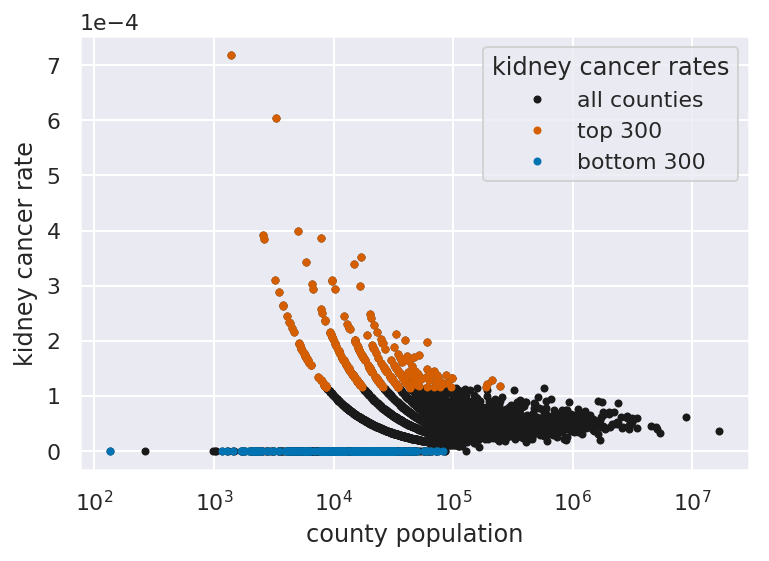

In [3]:
# function to plot all rates
def plot_rates(ax, df):
    # select cancer rate extremes
    field_y = "pct_mortality"
    df_low = df.nsmallest(300, field_y)
    df_high = df.nlargest(300, field_y)

    # display
    field_x = "pop"
    ax.semilogx(df[field_x], df[field_y], "k.", label="all counties")
    ax.semilogx(df_high[field_x], df_high[field_y], "r.", label="top 300")
    ax.semilogx(df_low[field_x], df_low[field_y], "b.", label="bottom 300")
    ax.set_xlabel("county population")
    ax.set_ylabel("kidney cancer rate")
    ax.legend(title="kidney cancer rates")
    
    return ax

# load data
df = pd.read_csv("kcancer.csv")

# display
fig, ax = plt.subplots()
plot_rates(ax, df)

There are a lot of counties with zero rates of kidney cancer recorded, making any trends a bit hard to see. Filtering out those counties and displaying the remaining top and bottom 300 unique, non-zero rates per county, we have something like this instead:

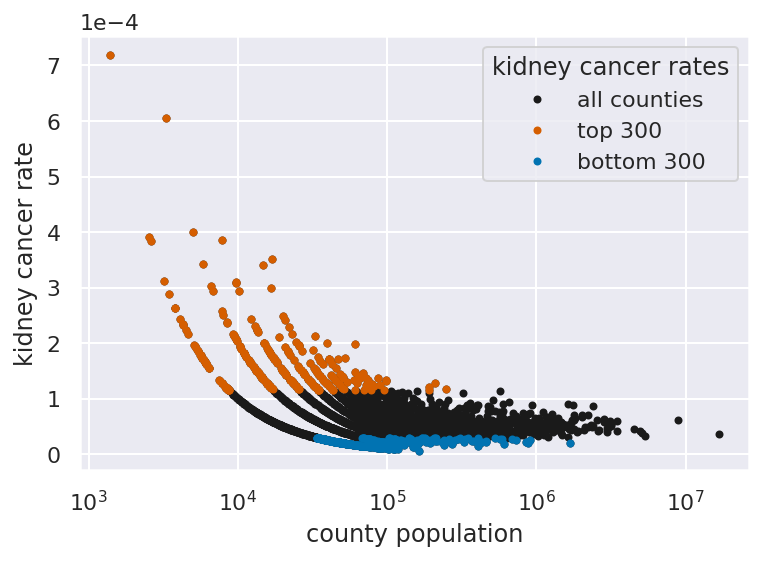

In [4]:
# filter out zero cancer rates 
field_x = "pct_mortality"
mask = (df[field_x] != 0)
df_filtered = df[mask]

# display
fig, ax = plt.subplots()
plot_rates(ax, df_filtered)

Now we see what looks like a trend that counties with smaller populations tend to have high reported kidney cancer rates and vice-versa. Counties with larger populations tend to have lower reported cancer rates.

#### 2.2 Empirical Bayes 

Ok. Big picture, we want to know what the distribution $(y_j|\alpha,\beta)$ looks like so that we can match the first and second moment of the cancer rate data (mean and variance) to the hopefully analytically determined moments of this distribution. We can then directly solve for what $\alpha$ and $\beta$ would be from this. Let's see if we can massage this distribution into a familiar Negative Binomial distribution then.

\begin{align}
p(y_j|\alpha,\beta) &= \int_0^\infty p(y_j|\theta_j)p(\theta_j|\alpha,\beta)
\text{ d}\theta_j, & \text{evidence} \\
&\sim \int_0^\infty \frac{(5n_j\theta_j)^{y_j}e^{-5n_j\theta_j}}{y_j!} 
\times \frac{\beta^\alpha}{\Gamma(\alpha)}\theta^{\alpha - 1}
e^{-\beta\theta_j}\text{ d}\theta_j, & \text{subbed in dists.} \\
&= \frac{(5n_j)^{y_j}\beta^\alpha}{y_j!\Gamma(\alpha)}
\int_0^\infty\theta_j^{\alpha + y_j - 1}e^{-(5n_j + \beta)\theta_j}
\text{ d}\theta_j, & \text{pulled out constants} \\
&= \frac{(5n_j)^{y_j}\beta^\alpha}{y_j!\Gamma(\alpha)}
\frac{\Gamma(\alpha + y_j)}{(5n_j + \beta)^{\alpha + y_j}},
& \text{applied identity}
\end{align}

where in the last step we applied the identity $\Gamma(x+1) = x!$ and the Gaussian integral identity

\begin{align}
\int_0^\infty x^n e^{-ax}\text{ d}x = 
\frac{n!}{a^{n + 1}} \quad.
\end{align}

Grouping the terms a bit more we get the Negative Binomial $(NB)$ distribution,

\begin{align}
p(y_j|\alpha,\beta) &= 
\frac{\Gamma(\alpha + y_j)}{y_j!\Gamma(\alpha)}
\left( \frac{\beta}{5n_j + \beta} \right)^\alpha
\left( \frac{5n_j}{5n_j + \beta} \right)^{y_j} \\
&= \frac{\Gamma(\alpha + y_j)}{y_j!\Gamma(\alpha)}
(1 - p_j)^\alpha p_j^{y_j} \\
&= \boxed{NB(\alpha,p_j),\text{ where } 
p_j = \frac{5n_j}{5n_j + \beta}}\quad.
\end{align}

Applying moment matching, we can now solve for $\alpha$ and $\beta$. The mean and variance for a $NB(\alpha, p)$ distribution is

\begin{align}
\mu = \frac{p\alpha}{1 - p},\quad
\sigma^2 = \frac{p\alpha}{(1 - p)^2} = \frac{\mu}{1 - p}\quad.
\end{align}

Applying this to our distribution, we have

\begin{align}
\mathbb E\left[ y_j \right] &= \frac{p_j\alpha}{1 - p_j}
= 5n_j \frac{\alpha}{\beta}\quad, \\
\text{Var}\left[ y_j \right] &= \frac{\mathbb E\left[ y_j \right]}{1 - p_j}
= \frac{5n_j\alpha}{\beta} \cdot \frac{5n_j + \beta}{\beta} \quad.
\end{align}

We are interested in comparing the Bayesian empirically estimated $y_j/n_j$ to the raw reported rates `pct_mortality` so we want to actually perform moment
matching on

\begin{align}
\mu_\theta &\equiv \widehat{\mathbb E}\left[ \frac{y_j}{n_j} \right]
= 5\frac{\alpha}{\beta} \quad, \\
\sigma^2_\theta &\equiv \widehat{\text{Var}}\left[ \frac{y_j}{n_j} \right]
= \frac{5}{\overline n_j} \cdot \frac{\alpha}{\beta}
\cdot \frac{5\overline n_j + \beta}{\beta} \quad,
\end{align}

where $n_j$ is the average county population. Now let's moment match. Solving for $\alpha/\beta$ in the first equation and plugging that into the second equation:

\begin{align}
\left( \frac{\alpha}{\beta} \right) = \frac{\mu_\theta}{5}
\quad\Longrightarrow\quad
\sigma_\theta^2 = \frac{5}{\overline n_j} \cdot \frac{\mu_\theta}{5}
\cdot \frac{5\overline n_j + \beta}{\beta} \quad.
\end{align}

Solving for $\beta$ gives,

\begin{align}
\overline n_j \frac{\sigma_\theta^2}{\mu_\theta}\beta
= 5\overline n_j + \beta 
\quad\Longrightarrow\quad
\boxed{\beta_\text{empirical} = \frac{5\overline n_j}
{\overline n_j\frac{\sigma_\theta^2}{\mu_\theta} - 1}} \quad.
\end{align}

Plugging this into our equation for the first moment, we then have

\begin{align}
\alpha = \frac{\mu_\theta}{5}\beta_\text{empirical}
\quad\Longrightarrow\quad 
\boxed{
\alpha_\text{empirical} = \frac{\mu_\theta\overline n_j}
{\overline n_j\frac{\sigma_\theta^2}{\mu_\theta} - 1}
} \quad.
\end{align}

We can now bootstrap a posterior predictive `theta_js` for 
$\theta_j | y, \alpha_\text{empirical}, \beta_\text{empirical}$ by sampling from $Gamma(\alpha_\text{empirical} + y_j, \beta_\text{empirical} + 5n_j)$ (as found in HW 3.2.2) multiple times and taking the mean on a per county basis:

In [5]:
# read in data
n_js, y_js, theta_js = df["pop"], df["dc"], df["pct_mortality"]

# empirically compute alpha and beta
n_mean, mu_theta, sigma2_theta = n_js.mean(), theta_js.mean(), theta_js.var()
denom = n_mean*sigma2_theta/mu_theta - 1.
alpha_emp = mu_theta*n_mean / denom
beta_emp = 5.*n_mean / denom

# print alpha and beta
print("Empirically determined parameters")
print("---------------------------------")
print(f"alpha: {alpha_emp}")
print(f"beta: {beta_emp}")

# compute posterior dist.
iters = 10_000
N = len(n_js)
theta_emp = np.zeros((iters, N))
for j, (nj, yj) in enumerate(zip(n_js, y_js)):
    theta_emp[:, j] = np.random.gamma(shape=alpha_emp + yj, 
                                  scale=1./(beta_emp + 5.*nj), 
                                  size=iters)
print("\nposterior computed")

Empirically determined parameters
---------------------------------
alpha: 1.5445945865954496
beta: 133464.15033286554

posterior computed


#### 2.3 Justification for Empirical Bayes

It is not a good idea to pick arbitrary values for $\alpha$ and $\beta$ in the case of this dataset because of the trend we saw in 1.1. Counties with smaller populations skew the cancer rate towards high values because even a small number of reported cases would artificially inflate the observed cancer rate.

#### 2.4 Posterior Means

The empirically determined posterior is plotted in green below along with the same raw data as in 1.1. The empirical estimates are shown with and without the zero reported cancer rate counties for clarity, respectively.

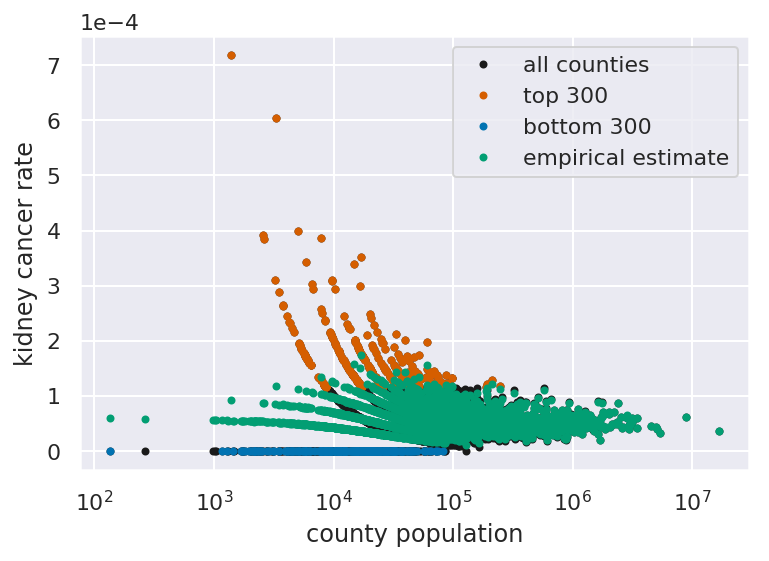

In [6]:
# with zero reported cancer rate counties included
fig, ax = plt.subplots()
plot_rates(ax, df)
theta_emp_mean = np.mean(theta_emp, axis=0)
ax.plot(n_js, 5*theta_emp_mean, "g.", label="empirical estimate")
ax.legend()

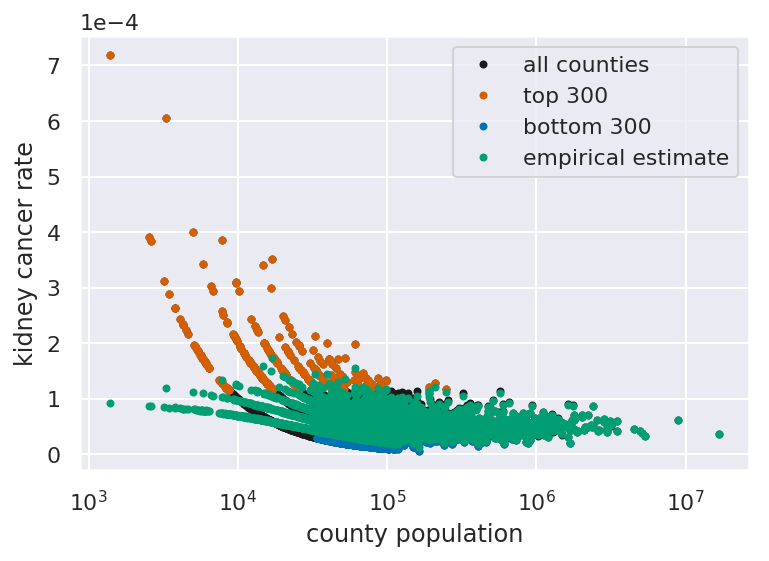

In [7]:
# with zero reported cancer rate counties excluded
fig, ax = plt.subplots()
plot_rates(ax, df[mask])
ax.plot(n_js[mask], 5*theta_emp_mean[mask], "g.", label="empirical estimate")
ax.legend()

As show above, using the posterior means (green) to estimate the cancer rates is preferable to studying the raw rates themselves because they are not as succeptible to small number bias (inflating the cancer rate for counties with small populations). The green points are seen to be consistently below their raw rate counterparts.

### Part II: Hierarchical Bayes
Rather than choosing fixed constants for the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j| \theta_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j | \alpha, \beta &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

1.  **(Posterior Marginal Means)** Produce a scatter plot of the raw cancer rates (pct mortality) vs the county population size. Highlight the top 300 raw cancer rates in red. Highlight the bottom 300 raw cancer rates in blue. Finally, on the same plot again, scatter plot the mean of the posterior marginal distribution over $\theta_j$, i.e. $p(\theta_j|y_1, \ldots, y_N)$, vs the county population size, highlight these means in orange. 

  You should use your sampler from the previous homework to obtain these posterior marginal samples.<br><br>

2.  **(Hierarchical Bayes vs Empirical Bayes)** Compare the shrinkage of the posterior marginal means of the hierarchical model to the shrinkage of the posterior means from the Bayesian model with empirical Bayes estimates for $\alpha, \beta$. What is the difference in shrinkage between the full hierarchical model and the Bayesian model with empirical Bayes?

#### 3.1 Posterior Marginal Means

We can use `pymc3` (Sijie said it's ok!) to sample from our hierarchical Bayesian model and plot the mean of the trace for each county in orange along with the raw data:

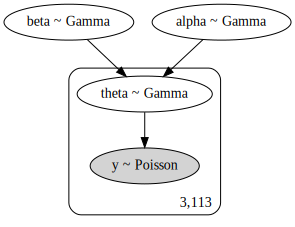

In [8]:
# load in data
n, y = df["pop"].values, df["dc"].values

#hyperparameters of hierarchical model
a=9
b=6
c=9
d=0.00001
 
#define hierarchical model in pymc3
with Model() as hiearchical_model:
    #hyperprior on alpha
    alpha = pm.Gamma('alpha', alpha=a, beta=b)
    #hyperprior on beta
    beta = pm.Gamma('beta', alpha=c, beta=d)
    #3,000 priors on theta
    theta = pm.Gamma('theta', alpha=alpha, beta=beta, shape=len(y))
    #convert rate into number of disease incidents
    mu = theta * 5 * n
    #likelihood
    y_obs = pm.Poisson('y', mu=mu, observed=y)
    
#draw associated graphical model  
model_to_graphviz(hiearchical_model)

In [9]:
# sample 1000 samples from the posterior of the hierarchical model
# using 1000 iterations to tune the sampler
with hiearchical_model:
    trace = pm.sample(1_000, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, beta, alpha]
100%|██████████| 2000/2000 [01:31<00:00, 21.79it/s]
The number of effective samples is smaller than 25% for some parameters.


Hierarchically determined parameters
---------------------------------
alpha: 10.930412266890704
beta: 1006644.8870443243


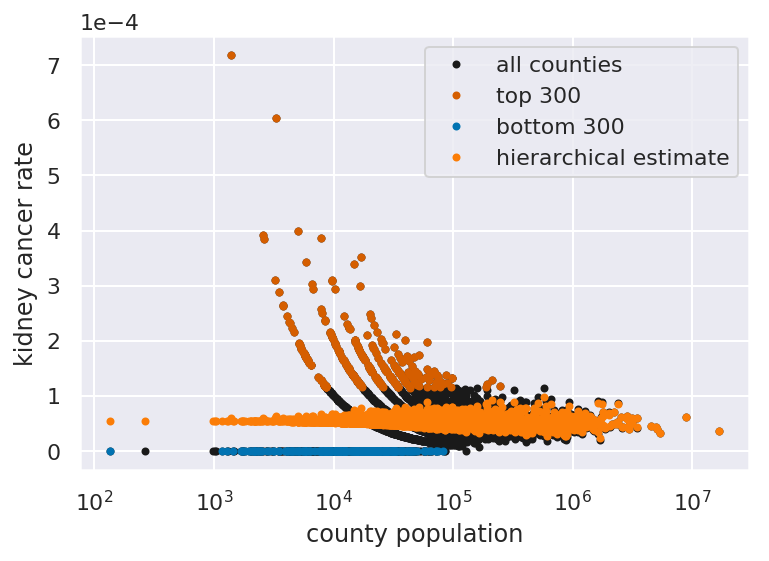

In [10]:
# plot results
theta_hier = np.mean(trace["theta"], axis=0)
alpha_hier, beta_hier = trace["alpha"].mean(), trace["beta"].mean()
fig, ax = plt.subplots()
plot_rates(ax, df)
ax.plot(n, 5*theta_hier, '.', color="#fb7d07", label="hierarchical estimate")
ax.legend()

# print alpha and beta
print("Hierarchically determined parameters")
print("---------------------------------")
print(f"alpha: {alpha_hier}")
print(f"beta: {beta_hier}")

This looks more promising. The underlying cancer rate is not as sensitive to population size now, which seems intuitive to me. We can also look at the trace of $\alpha$ and $\beta$ to see if the sampler is converging:

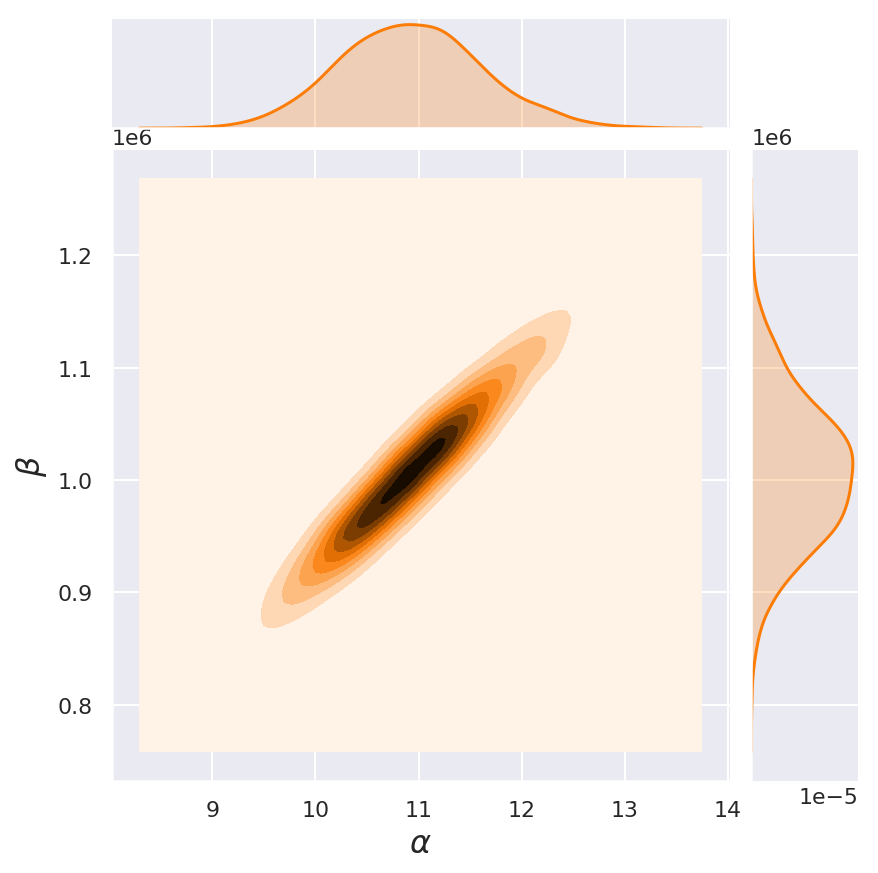

In [11]:
alphas, betas = trace["alpha"], trace["beta"]
p = sns.jointplot(alphas, betas, kind="kde", color="#fb7d07")
p.set_axis_labels(r"$\alpha$", r"$\beta$", fontsize=16)

The sampler is converging, and $\alpha$ and $\beta$ determined this way are significantly different that the empirically determined values. $\alpha$ and $\beta$ do look to be correlated though. 

We can compare the shrinkage of the posterior marginal means to get a handle on how each scheme did next.

#### 3.2 Hierarchical Bayes vs. Empirical Bayes

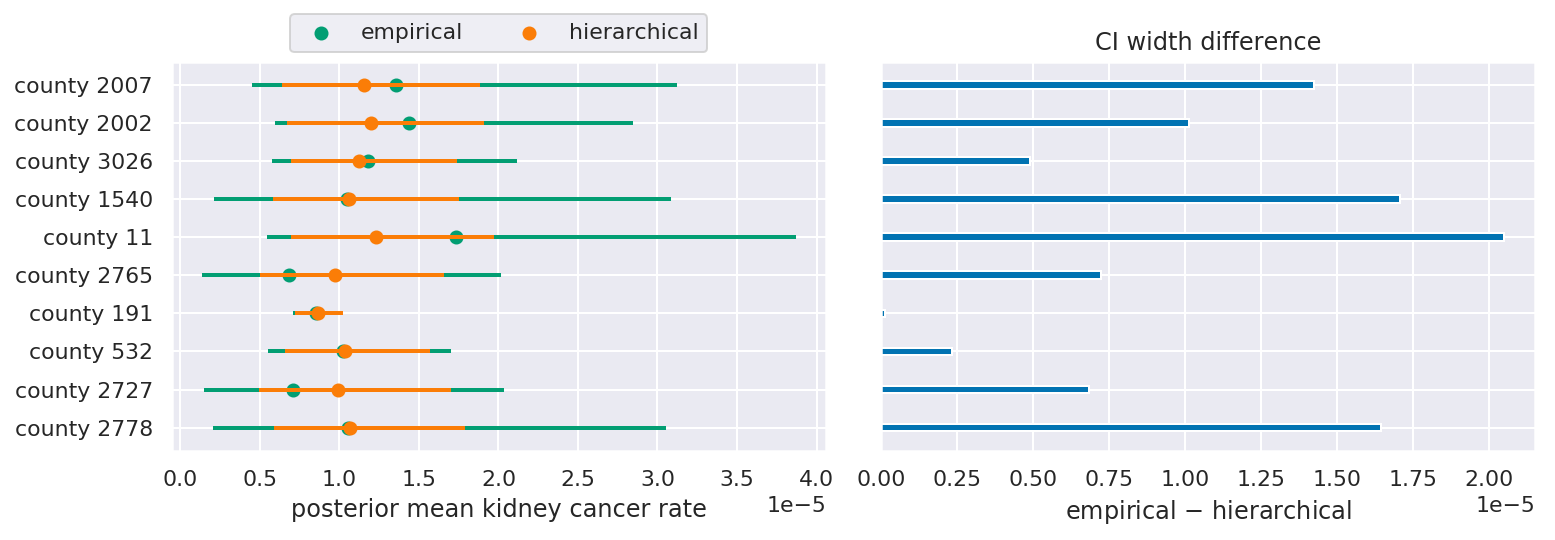

In [12]:
def plot_CIs(ax, d, d_name="county", n_selected=10, c='k', label=None, alpha=1, seed=0):
    # select `n_selected` random columns from `d`
    n_cols = d.shape[1]
    np.random.seed(seed)
    selected_idxs = np.random.choice(n_cols, n_selected, replace=False)
    selected_cols = d[:, selected_idxs]
    ax.scatter([], [], label=label, color=c) # for legend
    intervals = np.zeros(n_selected) # will hold CI width for each column
    for i, selected_d in enumerate(selected_cols.T):
        ub = np.percentile(selected_d, 97.5)
        mean = np.percentile(selected_d, 50.0)
        lb = np.percentile(selected_d, 2.5)
        ax.hlines(i, lb, ub, colors=c, linewidth=2, alpha=alpha)
        ax.scatter([mean], [i], color=c, alpha=alpha)
        intervals[i] = ub - lb
    ax.set_yticks(np.arange(n_selected))
    ax.set_yticklabels([f"{d_name} {i}" for i in selected_idxs])
    return ax, intervals

# display
fig, axes = plt.subplots(1, 2, figsize=fig_wide, sharey=True)
seed = np.random.randint(10_000) # so randomly selected counties are the same
p_emp, intervals_emp =  plot_CIs(axes[0], theta_emp, c='g', label="empirical", seed=seed)
p_hier, intervals_hier = plot_CIs(axes[0], trace["theta"], c="#fb7d07", label="hierarchical", seed=seed)

axes[0].ticklabel_format(axis='x', style="sci", scilimits=(-3, 3))
axes[0].set_xlabel("posterior mean kidney cancer rate")
axes[0].legend(ncol=2, loc=9, bbox_to_anchor=(0.5, 1.15))

CI_diff = intervals_emp - intervals_hier
axes[1].barh(range(len(CI_diff)), CI_diff, height=0.2)
axes[1].set_xlabel("empirical $-$ hierarchical")
axes[1].set_title("CI width difference")

fig.tight_layout()
    

For the randomly selected counties above, the posterior marginal means of the cancer rates tend to be more tightly constrained (more shrinkage) for the hierarchical (orange) approach than for the empirical (green) approach. The panel on the right shows the shrinkage on each county by taking the difference between the width of the confidence interval (upper bound $-$ minus lower bound) of the empirical and hierarchical models shown in the left panel.

#### Hand-rolled Sampler

Repeating the same analysis in 3.2 using my own sampler from HW3, I get the following:


Sampling completed in 3.24 seconds
Acceptance rate: 23.3%
(alpha, beta) = 10.84274816794306, 997783.9668699098

System and Sampler parameters
-----------------------------
N: 3113
y: [ 1. 15.  1. ...  1.  2.  0.]
n: [ 64915. 195253.  33987. ...  52910.  22814.  17802.]
a: 9
b: 6
c: 9
d: 1e-05
Sigma: [[1.e-01 0.e+00]
 [0.e+00 1.e+03]]
iters: 1000
init: [10.84372735699656, 998150.723166988]
custom determined parameters
---------------------------------
alpha: 10.843864461914126
beta: 998025.4339316824


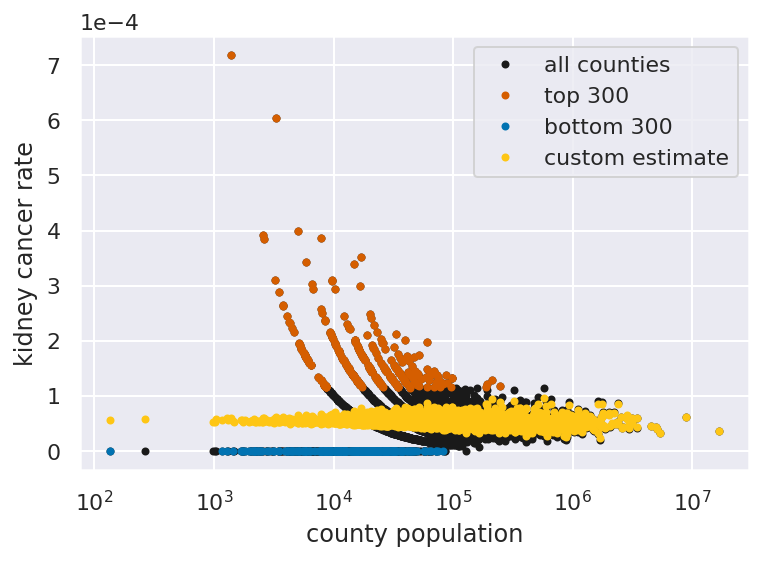

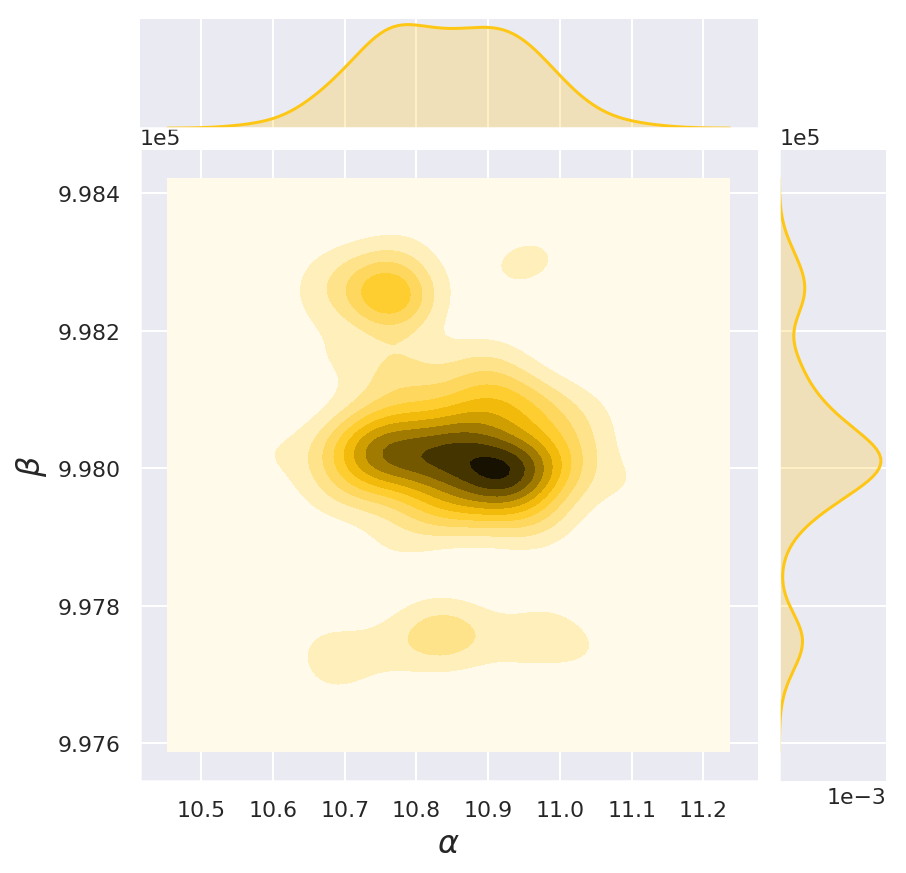

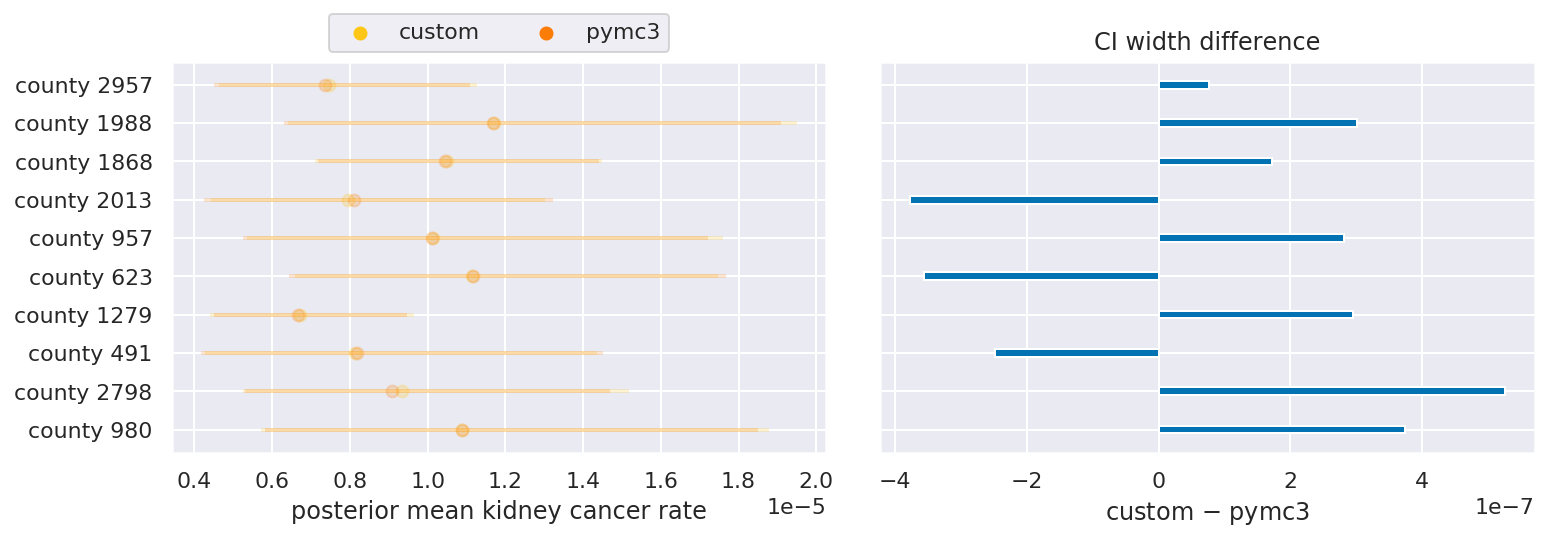

In [13]:
# load data
df = pd.read_csv("kcancer.csv")
params = {
    # system parameters
    'N': len(df), # Number of counties
    'y': df["dc"].to_numpy(), # number kidney cancer cases in each county
    'n': df["pop"].to_numpy(), # population of each county
    'a': 9, # p(alpha, beta | theta, y) parameters
    'b': 6,
    'c': 9,
    'd': 0.00001, 
    "Sigma": np.array([[0.1,     0.], # multivariate Gaussian proposal variance
                       [0.  , 1000.]]),
    # sampler parameters
    "iters":1_000, # sweeps
    "init":[10.84372735699656, 998150.723166988], # from pymc3
}

# samples theta_j for each county from easy conditional
def theta_cond(step):
    y, n = [params[k] for k in ['y', 'n']]
    alpha, beta = step
    return np.random.gamma(alpha + y, 1./(5.*n + beta))

# hard conditional
def log_p_alpha_beta_given_theta_y(step, theta_cond):
    a, b, c, d, N = [params[k] for k in ['a', 'b', 'c', 'd', 'N']]
    alpha, beta = step
    p1 = N*(alpha*np.log(beta) - np.log(st.special.gamma(alpha)))
    p2 = (alpha - 1.)*np.sum(np.log(theta_cond))
    p3 = -beta*np.sum(theta_cond) - d*beta - b*alpha
    p4 = (a - 1.)*np.log(alpha) + (c - 1.)*np.log(beta)
    return np.sum([p1, p2, p3, p4])
log_cond_hard = log_p_alpha_beta_given_theta_y

# proposal step to take 
def draw_proposal(step):
    Sigma = params["Sigma"]
    return np.random.multivariate_normal(step, Sigma)

# distribution proposal step is drawn from
def log_proposal(mu, x): 
    Sigma = params["Sigma"]
    return -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)

#implementation of the M-H in Gibbs sampler
sampler_params = {k:params[k] for k in ["init", "iters", "N"]}
def mh_in_gibbs(cond_easy, log_cond_hard, draw_proposal, log_proposal, sampler_params):
    step_current = sampler_params["init"]
    iters = sampler_params["iters"]
    N = sampler_params["N"]
    samples = np.zeros((iters, len(step_current))) 
    easy_vals = np.zeros((iters, N))
    samples[0, :] = step_current
    accept_count = 0
    for i in range(1, iters):
        # directly sample from easy conditional
        cond_easy_vals = cond_easy(step_current)

        # plug sample into hard conditional and take Metropolis-Hastings step
        #step_proposal = np.random.multivariate_normal(step_current, Sigma)
        #log_proposal = lambda mu, x: -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)
        log_U = np.log(np.random.uniform(0, 1))
        step_proposal = draw_proposal(step_current)
        log_alpha = (log_cond_hard(step_proposal, cond_easy_vals) -
                     log_proposal(step_current, step_proposal) -
                     log_cond_hard(step_current, cond_easy_vals) +
                     log_proposal(step_proposal, step_current))
        
        # take a step
        if log_U <= np.min((0, log_alpha)):
            step_current = step_proposal
            accept_count += 1
        else:
            pass
        
        # save results
        easy_vals[i, :] = cond_easy(step_current)
        samples[i, :] = step_current
        trace = {
            "theta":easy_vals, 
            "alpha":samples[:, 0],
            "beta":samples[:, 1],
        }
    return trace, 100.*(accept_count / iters)

# run
start = time.clock()
trace_custom, accept_rate_custom = mh_in_gibbs(theta_cond, log_cond_hard, draw_proposal, log_proposal,
                                   sampler_params)
end = time.clock() - start

# print sampler results
print(f"Sampling completed in {end:.2f} seconds")
print(f"Acceptance rate: {accept_rate_custom:.1f}%")
print(f"(alpha, beta) = {trace_custom['alpha'][-1]}, {trace_custom['beta'][-1]}\n")
print("System and Sampler parameters")
print("-----------------------------")
for k, v in params.items():
    print(f"{k}: {v}")

# burn and thin
burn = 10 # ignore first `burn`% of samples
thin = 10 # keep every `thin` samples
#trace_reduced = {k:v[int((burn/100.)*params['iters'])::thin, :] for k, v in trace.items()}
trace_reduced_custom = {k:v[int((burn/100.)*params['iters'])::thin] for k, v in trace_custom.items()}

# rates vs. pop. plot
theta_custom = np.mean(trace_reduced_custom["theta"], axis=0)
alpha_custom, beta_custom = trace_reduced_custom["alpha"].mean(), trace_reduced_custom["beta"].mean()
fig, ax = plt.subplots()
plot_rates(ax, df)
ax.plot(n, 5*theta_custom, '.', c="#fec615", label="custom estimate")
ax.legend()

# print alpha and beta again
print("custom determined parameters")
print("---------------------------------")
print(f"alpha: {alpha_custom}")
print(f"beta: {beta_custom}")

# joint plot
alphas_custom, betas_custom = trace_reduced_custom["alpha"], trace_reduced_custom["beta"]
p = sns.jointplot(alphas_custom, betas_custom, kind="kde", color="#fec615")
p.set_axis_labels(r"$\alpha$", r"$\beta$", fontsize=16)

# CI plots
fig, axes = plt.subplots(1, 2, figsize=fig_wide, sharey=True)
seed = np.random.randint(10_000) # so randomly selected counties are the same
p_custom, intervals_custom =  plot_CIs(axes[0], trace_custom["theta"], 
                                       c="#fec615", label="custom", alpha=0.2, seed=seed)
p_pymc3, intervals_pymc3 = plot_CIs(axes[0], trace["theta"], 
                                    c="#fb7d07", label="pymc3", alpha=0.2, seed=seed)
axes[0].ticklabel_format(axis='x', style="sci", scilimits=(-3, 3))
axes[0].set_xlabel("posterior mean kidney cancer rate")
axes[0].legend(ncol=2, loc=9, bbox_to_anchor=(0.5, 1.15))

CI_diff = intervals_custom - intervals_pymc3
axes[1].barh(range(len(CI_diff)), CI_diff, height=0.2)
axes[1].set_xlabel("custom $-$ pymc3")
axes[1].set_title("CI width difference")

fig.tight_layout()

The values for $\theta_j$, $\alpha$ and $\beta$ are pretty similar to the `pymc3` implementation ($\theta_j$ from each sampler within a percent of each other), but the parameters seem much less correlated (and the sampler took about twice as long to converge). There also seems to be some multi-modality going on in the posterior and $\beta$ that was not seen in the `pymc3` case.